

<h1><center>GRU4REC Demo on YOOCHOOSE Dataset</center></h1>

## Outline

- **Introduction**
- **Introduction to Session Based Recommender Systems**
- **Introduction to Method**
- **Code**
    - **Data**
        - **Data Loading**
        - **Data Preprocessing**
        - **Data Loader**
    - **Model**
         - **Model Definition**
         - **Hyperparameter Settings**
         - **Loss Function**
         - **Metrics for Method**
    - **Training, Validation and Testing**

# Introduction  

<html>
<head>
<meta name="viewport" content="width=device-width, initial-scale=1">
<style>
img {
  display: block;
  margin-left: auto;
  margin-right: auto;
}
</style>
</head>
<body>

<figure>
<img src="https://repository-images.githubusercontent.com/509431804/257cfdcb-cab6-4260-b210-01ae6ca4613a" alt="recsys" style="width:50%;">
</figure>

</body>
</html>

Today, recommendation systems are ubiquitous, spanning sectors as diverse as 


*   online retail,
*   music and video streaming and
*   content publishing.

<h2 >Why Recommender Systems matter? </h2>

*   We can discover **what's interesting or important** to us among the vast amount of content on the internet. 

*   A recommendation system can assist us in **navigating more efficiently** and making better decisions when it is implemented correctly.

## Introduction to Session-Based Recommender Systems

It is almost always the case that choices have a time-sensitive context; for example, some items may be more relevant than others based on **when they were last viewed** or **purchased**.

Despite being embedded in the user's most recent interactions, short-term preferences may only represent a small portion of history. Additionally, a user's preference for certain items can be **dynamic rather than static**; it can evolve over time. 

As a result, **session-based recommendation** algorithms have been developed, which **rely heavily on the user's recent interactions** instead of their historical preferences. Moreover, this approach is especially advantageous since **a user may appear anonymously** if they are not logged in or browsing incognito.  

<html>
<head>
<meta name="viewport" content="width=device-width, initial-scale=1">
<style>
img {
  display: block;
  margin-left: auto;
  margin-right: auto;
}
</style>
</head>
<body>



<figure>
<img src="https://session-based-recommenders.fastforwardlabs.com/figures/FF19_Artboard_3rev.png" alt="" style="width:80%;>
<figcaption align = "center"><b>Users’ preference can change over time</b></figcaption>
</figure>

</body>
</html>

<h2>Benefits of Session-Based Recommender Systems</h2>



*   These methods can be implemented even in the **absence of historical user data**, and doesn’t explicitly rely on user population statistics. This is helpful because, as just noted above, users aren’t always logged in when they browse a website.

*   A wealth of new, **publicly available, session-centric datasets** have been released, especially in the e-commerce domain, allowing for model development and research in this area.

*   Session-based recommenders can benefit from the rise of **deep learning approaches** expressly suited for sequences.


<h2>Defining the Session-based Recommender Problem Space</h2>

A new customer, has been browsing tops, shoes, and weights. The browsing history looks like this:

<html>
<head>
<meta name="viewport" content="width=device-width, initial-scale=1">
<style>
img {
  display: block;
  margin-left: auto;
  margin-right: auto;
}
</style>
</head>
<body>



<figure>
<img src="https://session-based-recommenders.fastforwardlabs.com/figures/FF19_Artboard_4rev.png" alt="" style="width:80%;>
<figcaption align = "center">
</figure>

</body>
</html>

<h3> What should we recommend to the user next? </h3>

**Good recommendations** will **increase the likelihood** that the user will see something they like, click on it, and make a purchase. **Poor recommendations** will, at best, lead to no new revenue, but even worse could give them **a negative customer experience**.

We’ll consider their **recent browsing history** as a **session**. Formally, a session is composed of **multiple user interactions that happen together in a continuous period of time**.

Our goal is to predict the product within user’s session that they will like enough to click on. This task is called **next event prediction (NEP)**: given a series of events (user’s browsing history), we want to predict the next event (user clicking on a product we recommend to them).

<html>
<head>
<meta name="viewport" content="width=device-width, initial-scale=1">
<style>
img {
  display: block;
  margin-left: auto;
  margin-right: auto;
}
</style>
</head>
<body>



<figure>
<img src="https://session-based-recommenders.fastforwardlabs.com/figures/FF19_Artboard_5.png" alt="" style="width:80%;>
<figcaption align = "center" > <b>Historical browsing sessions of various lengths</b></figcaption>
</figure>

</body>
</html>

In reality, this means that our model might generate a handful of recommendations based on user’s browsing history; we want to **maximize the likelihood** that user clicks on at least one of them. To train a model for this task, we’ll need to use historical browsing sessions from our other existing users to identify trends between products that will help us learn recommendations.

## Introduction to Method

The method covered in this demo is <a href="https://arxiv.org/pdf/1511.06939.pdf" title="Session-based recommendations with recurrent neural networks">**Session-Based Recommendations with Recurrent Nneural Networks**</a>.


The real-life recommender systems often have to make recommendations based on **short session data**. Among the main approaches employed in the session-based recommendation is the **item-to-item recommendation approach**, which is a natural solution to the problem of **a missing user profile**. From the session data, an item-to-item similarity matrix is precomputed, meaning items that are often clicked together in sessions are deemed similar. The similarity matrix is used during the session to recommend items most similar to the one the user is currently viewing. Although effective, these methods **only consider the last click of the user**, ignoring past clicks in effect. In practice, it is argued that **more accurate recommendations can be provided by modeling the whole session**. A session-based recommendation system based on RNNs is therefore proposed in this notebook.

# Code  

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import argparse
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from tensorflow import keras
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.layers import Input, Dense, Dropout, GRU

## Data

The **YOOCHOOSE dataset** contains a collection of **sessions from a retailer**, where each session contains the **click events** that the user performed. There are also **buy events** for some sessions. This means that the user purchased something from the web shop at the end of the session. Data was collected from the clicks and purchases made by users of an online retailer in Europe over several months in 2014.

<html>
<head>
<meta name="viewport" content="width=device-width, initial-scale=1">
<style>
img {
  display: block;
  margin-left: auto;
  margin-right: auto;
}
</style>
</head>
<body>



<figure>
<img src="https://miro.medium.com/max/510/1*CcmsurWO-DuYSzVCy7Pf7g.png" alt="" style="width:50%;>
<figcaption align = "center" > 
</figure>

</body>
</html>

### Data Loading

In [2]:
PATH_TO_DATA = "/ssd003/projects/aieng/public/recsys_datasets/yoochoose/"

In [3]:
data = pd.read_csv(PATH_TO_DATA + 'yoochoose-clicks.dat', sep=',', header=None, usecols=[0,1,2], dtype={0:np.int32, 1:str, 2:np.int64})
data.columns = ['SessionId', 'TimeStr', 'ItemId']
data['Time'] = data.TimeStr.apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%fZ').timestamp()) #This is not UTC. It does not really matter.
del(data['TimeStr'])

### Data Preprocessing

We keep only the click events. The network is trained on ∼ **6 months** of data, containing 7,966,257 sessions of 31,637,239 clicks on 37,483 items. We use the sessions of the **subsequent day for testing**. Each session is assigned to either the training or the test set, we do not split the data mid-session. Because of the nature of collaborative filtering methods, we filter out clicks from the test set where the item clicked is not in the train set. Sessions of length one are removed from both the training and the test set. We filtered out items that appear less than 5 times. After the preprocessing we are left with **15,324 sessions of 71,222 events** for the **test set**.

In [4]:
session_lengths = data.groupby('SessionId').size()
data = data[np.in1d(data.SessionId, session_lengths[session_lengths>1].index)]
item_supports = data.groupby('ItemId').size()
data = data[np.in1d(data.ItemId, item_supports[item_supports>=5].index)]
session_lengths = data.groupby('SessionId').size()
data = data[np.in1d(data.SessionId, session_lengths[session_lengths>=2].index)]

In [5]:
tmax = data.Time.max()
session_max_times = data.groupby('SessionId').Time.max()
session_train = session_max_times[session_max_times < tmax-86400].index # 86400 secconds is one day
session_test = session_max_times[session_max_times >= tmax-86400].index # 86400 secconds is one day
train = data[np.in1d(data.SessionId, session_train)]
train.to_csv('../../rsc15_train_full.txt', sep='\t', index=False)
print('Full train set\n\tEvents: {}\n\tSessions: {}\n\tItems: {}'.format(len(train), train.SessionId.nunique(), train.ItemId.nunique()))

test = data[np.in1d(data.SessionId, session_test)]
test = test[np.in1d(test.ItemId, train.ItemId)]
tslength = test.groupby('SessionId').size()
test = test[np.in1d(test.SessionId, tslength[tslength>=2].index)]
test.to_csv('../../rsc15_test.txt', sep='\t', index=False)
print('Test set\n\tEvents: {}\n\tSessions: {}\n\tItems: {}'.format(len(test), test.SessionId.nunique(), test.ItemId.nunique()))


tmax = train.Time.max()
session_max_times = train.groupby('SessionId').Time.max()
session_train = session_max_times[session_max_times < tmax-86400].index # 86400 secconds is one day
session_valid = session_max_times[session_max_times >= tmax-86400].index # 86400 secconds is one day
train_tr = train[np.in1d(train.SessionId, session_train)]
valid = train[np.in1d(train.SessionId, session_valid)]
valid = valid[np.in1d(valid.ItemId, train_tr.ItemId)]
tslength = valid.groupby('SessionId').size()
valid = valid[np.in1d(valid.SessionId, tslength[tslength>=2].index)]
train_tr.to_csv('../../rsc15_train_tr.txt', sep='\t', index=False)
print('Train set\n\tEvents: {}\n\tSessions: {}\n\tItems: {}'.format(len(train_tr), train_tr.SessionId.nunique(), train_tr.ItemId.nunique()))
valid.to_csv('../../rsc15_train_valid.txt', sep='\t', index=False)
print('Validation set\n\tEvents: {}\n\tSessions: {}\n\tItems: {}'.format(len(valid), valid.SessionId.nunique(), valid.ItemId.nunique()))

Full train set
	Events: 31637239
	Sessions: 7966257
	Items: 37483
Test set
	Events: 71222
	Sessions: 15324
	Items: 6751
Train set
	Events: 31579006
	Sessions: 7953885
	Items: 37483
Validation set
	Events: 58233
	Sessions: 12372
	Items: 6359


### Data Loader

RNNs for natural language processing tasks usually use in-sequence mini-batches. This does not fit our task, because:

1.   the **length of sessions can be very different**, even more so than that of sentences: some sessions consist of only 2 events, while others may range over a few hundreds
2.   our goal is to capture **how a session evolves over time**, so breaking down into fragments would make no sense.


Therefore we use **session-parallel mini-batches**. First, we create an order for the sessions. Then, we use the first event of the first X sessions to form the input of the first mini-batch (the desired output is the second events of our active sessions). The second mini-batch is formed from the second events and so on.

<html>
<head>
<meta name="viewport" content="width=device-width, initial-scale=1">
<style>
img {
  display: block;
  margin-left: auto;
  margin-right: auto;
}
</style>
</head>
<body>



<figure>
<img src="https://www.researchgate.net/profile/Alexandros-Karatzoglou/publication/284579100/figure/fig2/AS:614315157631010@1523475555939/Session-parallel-mini-batch-creation.png" alt="" style="width:50%;>
<figcaption align = "center" >
</figure>

</body>
</html>

In [6]:
class SessionDataset:
    def __init__(self, data, sep='\t', session_key='SessionId', item_key='ItemId', time_key='Time', n_samples=-1, itemmap=None, time_sort=False):
        """
        Args:
            path: path of the csv file
            sep: separator for the csv
            session_key, item_key, time_key: name of the fields corresponding to the sessions, items, time
            n_samples: the number of samples to use. If -1, use the whole dataset.
            itemmap: mapping between item IDs and item indices
            time_sort: whether to sort the sessions by time or not
        """
        self.df = data
        self.session_key = session_key
        self.item_key = item_key
        self.time_key = time_key
        self.time_sort = time_sort
        self.add_item_indices(itemmap=itemmap)
        self.df.sort_values([session_key, time_key], inplace=True)

        # Sort the df by time, and then by session ID. That is, df is sorted by session ID and
        # clicks within a session are next to each other, where the clicks within a session are time-ordered.

        self.click_offsets = self.get_click_offsets()
        self.session_idx_arr = self.order_session_idx()

    def get_click_offsets(self):
        """
        Return the offsets of the beginning clicks of each session IDs,
        where the offset is calculated against the first click of the first session ID.
        """
        offsets = np.zeros(self.df[self.session_key].nunique() + 1, dtype=np.int32)
        # group & sort the df by session_key and get the offset values
        offsets[1:] = self.df.groupby(self.session_key).size().cumsum()

        return offsets

    def order_session_idx(self):
        """ Order the session indices """
        if self.time_sort:
            # starting time for each sessions, sorted by session IDs
            sessions_start_time = self.df.groupby(self.session_key)[self.time_key].min().values
            # order the session indices by session starting times
            session_idx_arr = np.argsort(sessions_start_time)
        else:
            session_idx_arr = np.arange(self.df[self.session_key].nunique())

        return session_idx_arr

    def add_item_indices(self, itemmap=None):
        """
        Add item index column named "item_idx" to the df
        Args:
            itemmap (pd.DataFrame): mapping between the item Ids and indices
        """
        if itemmap is None:
            item_ids = self.df[self.item_key].unique()  # unique item ids
            item2idx = pd.Series(data=np.arange(len(item_ids)),
                                 index=item_ids)
            itemmap = pd.DataFrame({self.item_key:item_ids,
                                   'item_idx':item2idx[item_ids].values})

        self.itemmap = itemmap
        self.df = pd.merge(self.df, self.itemmap, on=self.item_key, how='inner')

    @property
    def items(self):
        return self.itemmap.ItemId.unique()


class SessionDataLoader:
    def __init__(self, dataset, batch_size=50):
        """
        A class for creating session-parallel mini-batches.
        Args:
            dataset (SessionDataset): the session dataset to generate the batches from
            batch_size (int): size of the batch
        """
        self.dataset = dataset
        self.batch_size = batch_size
        self.done_sessions_counter = 0

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        df = self.dataset.df
        session_key='SessionId'
        item_key='ItemId'
        time_key='TimeStamp'
        self.n_items = df[item_key].nunique()+1
        click_offsets = self.dataset.click_offsets
        session_idx_arr = self.dataset.session_idx_arr

        iters = np.arange(self.batch_size)
        maxiter = iters.max()
        start = click_offsets[session_idx_arr[iters]]
        end = click_offsets[session_idx_arr[iters] + 1]
        mask = [] # indicator for the sessions to be terminated
        finished = False

        while not finished:
            minlen = (end - start).min()
            # Item indices (for embedding) for clicks where the first sessions start
            idx_target = df.item_idx.values[start]
            for i in range(minlen - 1):
                # Build inputs & targets
                idx_input = idx_target
                idx_target = df.item_idx.values[start + i + 1]
                inp = idx_input
                target = idx_target
                yield inp, target, mask

            # click indices where a particular session meets second-to-last element
            start = start + (minlen - 1)
            # see if how many sessions should terminate
            mask = np.arange(len(iters))[(end - start) <= 1]
            self.done_sessions_counter = len(mask)
            for idx in mask:
                maxiter += 1
                if maxiter >= len(click_offsets) - 1:
                    finished = True
                    break
                # update the next starting/ending point
                iters[idx] = maxiter
                start[idx] = click_offsets[session_idx_arr[maxiter]]
                end[idx] = click_offsets[session_idx_arr[maxiter] + 1]

## Model

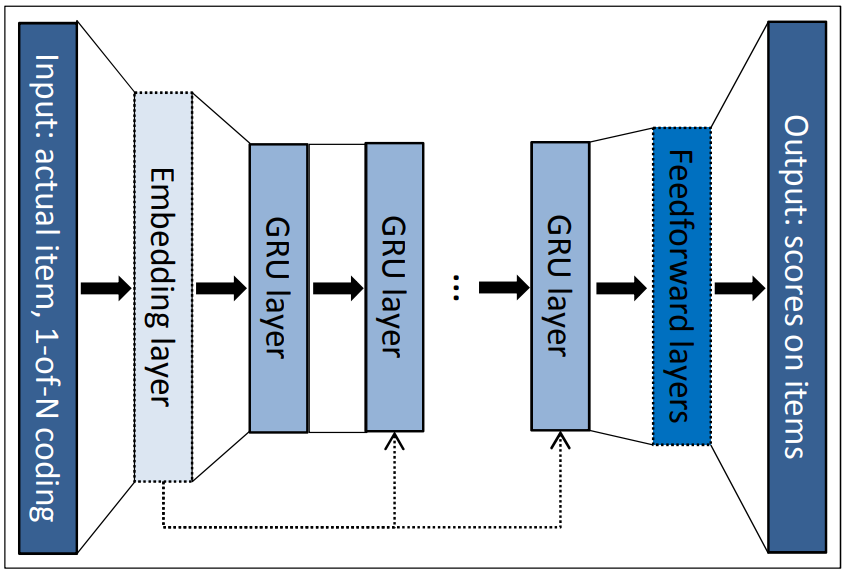

This method uses **GRU-based** RNNs for session-based recommendations. 

The **input of the network** is the **actual state of the session**, while the **output** is the **item of the next event**. 

The session state can either be the item of the actual event or the events in the session so far. The input vector's length equals the number of items, and only the coordinate corresponding to the active item is one, the others are zeros.

The GRU layer(s) is the core of the network, and additional feedforward layers can be added between it and the output. In this case, the output is a predicted preference, i.e. the likelihood of each item being next in the session. The hidden state of the previous layer becomes the input for the next layer when multiple GRU layers are used.

### Model Definition

In [7]:
def create_model(hidden_units, batch_size, train_n_items):
    inputs = Input(batch_shape=(batch_size, 1, train_n_items))
    gru, gru_states = GRU(hidden_units, stateful=True, return_state=True, name="GRU")(inputs)
    drop2 = Dropout(0.25)(gru)
    predictions = Dense(train_n_items, activation='softmax')(drop2)
    model = Model(inputs=inputs, outputs=[predictions])

    return model

### Hyperparameter Settings

In [8]:
batch_size = 512
hidden_units = 100
train_n_items = len(train['ItemId'].unique()) + 1

In [9]:
model = create_model(hidden_units, batch_size, train_n_items)

2022-09-13 15:38:58.143158: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-13 15:38:59.324671: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13795 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:87:00.0, compute capability: 7.5


### Loss Function 

In [10]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=categorical_crossentropy, optimizer=opt)

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(512, 1, 37484)]         0         
                                                                 
 GRU (GRU)                   [(512, 100),              11275800  
                              (512, 100)]                        
                                                                 
 dropout (Dropout)           (512, 100)                0         
                                                                 
 dense (Dense)               (512, 37484)              3785884   
                                                                 
Total params: 15,061,684
Trainable params: 15,061,684
Non-trainable params: 0
_________________________________________________________________


### Metrics for Method

We can evaluate the method with the following metrics:

- **Recall at K (Recall@K)**: It is the proportion of test cases in which the ground truth item is among the top K recommendations (a test example receives a score of 1 when the nth item appears, and 0 otherwise).

<html>
<head>
<meta name="viewport" content="width=device-width, initial-scale=1">
<style>
img {
  display: block;
  margin-left: auto;
  margin-right: auto;
}
</style>
</head>
<body>



<figure>
<img src="https://miro.medium.com/max/1400/1*4idLDQc9FiyCMXy8Ck-LSA.png" alt="" width="300" height="200";>
<figcaption align = "center" >
</figure>

</body>
</html>

- **Mean Reciprocal Rank at K (MRR@K)**: For all test cases, the average reciprocal rank of the ground truth items within the top K recommendations is taken (for example, if the nth item was second in the list, its reciprocal rank would be 1/2). As a result of this metric, higher rankings are preferred in the ordered list of recommendation results.

<html>
<head>
<meta name="viewport" content="width=device-width, initial-scale=1">
<style>
img {
  display: block;
  margin-left: auto;
  margin-right: auto;
}
</style>
</head>
<body>



<figure>
<img src="https://miro.medium.com/max/872/1*Yz8One3GN-vJfQxy6n2rAw.png" alt="" width="220" height="">
<figcaption align = "center" >
</figure>

</body>
</html>

In [20]:
def get_metrics(model, test, train_generator_map, recall_k=20, mrr_k=20):

    test_dataset = SessionDataset(test, itemmap=train_generator_map)
    test_generator = SessionDataLoader(test_dataset, batch_size=batch_size)

    n = 0
    rec_sum = 0
    mrr_sum = 0

    print("Evaluating model...")
    for feat, label, mask in test_generator:

        gru_layer = model.get_layer(name="GRU")
        hidden_states = gru_layer.states[0].numpy()
        for elt in mask:
            hidden_states[elt, :] = 0
        gru_layer.reset_states(states=hidden_states)

        target_oh = to_categorical(label, num_classes=train_n_items)
        input_oh  = to_categorical(feat,  num_classes=train_n_items)
        input_oh = np.expand_dims(input_oh, axis=1)

        pred = model.predict(input_oh, batch_size=batch_size, verbose=0)

        for row_idx in range(feat.shape[0]):
            pred_row = pred[row_idx]
            label_row = target_oh[row_idx]

            rec_idx =  pred_row.argsort()[-recall_k:][::-1]
            mrr_idx =  pred_row.argsort()[-mrr_k:][::-1]
            tru_idx = label_row.argsort()[-1:][::-1]

            n += 1

            if tru_idx[0] in rec_idx:
                rec_sum += 1

            if tru_idx[0] in mrr_idx:
                mrr_sum += 1/int((np.where(mrr_idx == tru_idx[0])[0]+1))

    recall = rec_sum/n
    mrr = mrr_sum/n
    return (recall, recall_k), (mrr, mrr_k)

## Training, Validation and Testing

In [17]:
epochs = 10
train_n_items = len(train['ItemId'].unique()) + 1
train_samples_qty = len(train['SessionId'].unique()) + 1
test_samples_qty = len(test['SessionId'].unique()) + 1

train_dataset = SessionDataset(train)

In [ ]:
for epoch in range(1, epochs + 1):
    with tqdm(total=train_samples_qty) as pbar:
        loader = SessionDataLoader(train_dataset, batch_size=batch_size)
        for feat, target, mask in loader:

            gru_layer = model.get_layer(name="GRU")
            hidden_states = gru_layer.states[0].numpy()
            for elt in mask:
                hidden_states[elt, :] = 0
            gru_layer.reset_states(states=hidden_states)

            input_oh = to_categorical(feat, num_classes=loader.n_items)
            input_oh = np.expand_dims(input_oh, axis=1)

            target_oh = to_categorical(target, num_classes=loader.n_items)

            tr_loss = model.train_on_batch(input_oh, target_oh)

            pbar.set_description("Epoch {0}. Loss: {1:.5f}".format(epoch, tr_loss))
            pbar.update(loader.done_sessions_counter)

    print("Saving weights...")
    model.save('../../GRU4REC_{}.h5'.format(epoch))

    (rec, rec_k), (mrr, mrr_k) = get_metrics(model, test, train_dataset.itemmap, recall_k=20, mrr_k=20)
    print("\t - Recall@{} epoch {}: {:5f}".format(rec_k, epoch, rec))
    print("\t - MRR@{}    epoch {}: {:5f}\n".format(mrr_k, epoch, mrr))

In [18]:
model.load_weights("/ssd003/projects/aieng/public/recsys_ckpts/GRU4REC.h5")

In [21]:
(rec, rec_k), (mrr, mrr_k) = get_metrics(model, test, train_dataset.itemmap, recall_k=20, mrr_k=20)

Evaluating model...


In [23]:
print("Recall@{}: {:5f}".format(rec_k, rec))
print("MRR@{}: {:5f}\n".format(mrr_k, mrr))

Recall@20: 0.719952
MRR@20: 0.316040



<h2> Result Compared to baselines </h2>

| Methods/Metrics      | Recall@20 | MRR@20     |
| :---        |    :----:   |          ---: |
| POP      | 0.0050       | 0.0012   |
| S-POP   | 0.2672        | 0.1775      |
| BPR-MF   | 0.2574        | 0.0618      |
| Item-KNN      | 0.5065       | 0.2048   |
| **GRU4Rec**   | **0.719952**        | **0.316040**      |

# References

1. <a href="https://arxiv.org/pdf/1511.06939.pdf" title="Session-based recommendations with recurrent neural networks">Hidasi, Balázs, et al. Session-based recommendations with recurrent neural networks.</a>
2. https://github.com/paxcema/KerasGRU4Rec
3. https://session-based-recommenders.fastforwardlabs.com